# Preliminary study on VLLS and VLLD yields

I am considering the 2018 scenario with luminosity 59.8 fb$^{-1}$. I am investigating the singlet as well as the doublet models of VLL in purely electron like, and purely muon like scenarios. The following are the final states that I am interested in.
- 4L (inclusive)
- Exactly 3L
- Exactly 2L (OS and SS)
- Exactly 1L and XJ (X = 2+, 1, 0)
  
These final states are orthogonal to each other and the filling order does not matter.

### Object and event selections
I am picking medium ID electrons and muon as L with pT>10 and fabs(eta)<2.4 <br>
The Jets have pT>30 and abs(eta)<2.3 with standard selections.<br>
These reco objects are dR-cleaned by 0.5 from the other loose objects.
Here is a link to the details of object selections - https://github.com/phazarik/VLLSearch-Run3/blob/main/Setup/ProduceRecoCollection.h <br>
Here is a link to the details of event selections - https://github.com/phazarik/VLLSearch-Run3/blob/prachu_2LSS/Setup/EventSelection.h

### Trigger and cuts
The event should have at least one muon with pT>26 GeV, or one electron with pT>35 GeV. Right now I am not considering whether this lepton should be a part of the final state object or not (for channels containing more than one leptons). **There are no additional cuts right now.** Later, more cuts will be put on the individual channels to purify signals, which will bring down the acceptance and yield.

### Corrections for the doublet models
The VLLD models contain some <span style="color:red;">invalid</span> decay modes which are mentioned below.<br>
<div style="text-align:center;">
    $L\rightarrow W\nu_\tau$<br>
    $N\rightarrow H\nu_\tau, Z\nu_\tau$
</div>
We calculate acceptance by doing <code>nevt_in_channel/nevt_in_file</code>. However, in this case, the denomnator itself is reducing because of the event flag I used to get rid of these invalid decays. These is no such modification to the singlet models.

In [1]:
import ROOT
import os, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
print('modules loaded.')

Welcome to JupyROOT 6.26/10
modules loaded.


In [2]:
jobname = 'hist_2018UL_Jul24_signal'

#signal_file = 'signal_database.json'
lumidata = '../../../InputJsons/lumidata_2018.json'
with open(lumidata, 'r') as file: json_data = json.load(file)
print('Signal database loaded!')

datestamp = datetime.today().strftime('%Y-%m-%d')
plotdir = 'plots/'+datestamp
os.system(f'mkdir -p {plotdir}')
print('Plot directory ready!')

thin_line = {
    'marker':'o',
    'linestyle':'--',
    'markersize':3,
    'linewidth':1
}
thick_line = {
    'marker':'o',
    'linestyle':'-',
    'markersize':4,
    'linewidth':2
}

masses = [100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 600, 750, 800, 1000]

def accp(num, den):
    if den==0 : return 0
    else : return (num/den)*100

def lumiscale(lumi):
    datalumi = 59800
    scale = datalumi/lumi
    return scale

def put_text(ax):
    ax.text(0, 1.03, "CMS", transform=ax.transAxes, fontsize=12, fontweight='bold')
    ax.text(0.16, 1.03, "preliminary", transform=ax.transAxes, fontsize=12, fontstyle='italic')

print('settings loaded.')

Signal database loaded!
Plot directory ready!
settings loaded.


In [3]:
json_data

{'DYJetsToLL': {'M10to50': 5925.522, 'M50': 30321.155},
 'HTbinnedWJets': {'70to100': 52100.91,
  '100to200': 41127.174,
  '200to400': 172265.183,
  '400to600': 163821.083,
  '600to800': 708793.021,
  '800to1200': 1481985.193,
  '1200to2500': 5602003.457,
  '2500toInf': 79396214.989},
 'QCD_MuEnriched': {'20to30': 23.893,
  '30to50': 42.906,
  '50to80': 105.88,
  '80to120': 508.715,
  '120to170': 1802.854,
  '170to300': 10265.815,
  '300to470': 95249.242,
  '470to600': 656872.156,
  '600to800': 2060827.812,
  '800to1000': 11337379.457},
 'QCD_EMEnriched': {'15to20': 5.96666541,
  '20to30': 2.92664338,
  '30to50': 1.33001225,
  '50to80': 5.28031791,
  '80to120': 25.76427755,
  '120to170': 145.33569605,
  '170to300': 223.50433213,
  '300toInf': 2007.24094203},
 'SingleTop': {'s-channel_LeptonDecays': 5456748.098,
  't-channel_AntiTop_InclusiveDecays': 1407728.544,
  't-channel_Top_InclusiveDecays': 1572627.866,
  'tW_AntiTop_InclusiceDecays': 238357.428,
  'tW_Top_InclusiveDecays': 24517

#### Preparing the function to fillup a dictionary with acceptance and yields across the mass-points

In [4]:
def check_yields(model):
    plotdict = {
        '1L0J':{'color':'yellow',},
        '1L1J':{'color':'gold'},
        '1L2J':{'color':'orange'},
        '2LOS':{'color':'blue'},
        '2LSS':{'color':'darkblue'},
        '3L'  :{'color':'green'},
        '4L'  :{'color':'red'}
    }

    print(f'Yield (acceptance %) for {model} :')
    print(f'mass\tnRAW\tn1L0J\t\tn1L1J\t\tn1L2J\t\tn2LOS\t\tn2LSS\t\tn3L\t\tn4L')
    
    for mass in masses:
        for key, val in json_data.items():
            if key == model:
                
                filename = f'input_hists/{jobname}/hst_{model}_M{str(mass)}.root'
                file_exists = os.path.exists(filename)
                
                if file_exists:
                    tfile = ROOT.TFile(filename)
                    hist = tfile.Get(f'finalstates_incldecay')
                    nall = hist.GetBinContent(1)
                    
                    print(f'\n{mass}\t{int(nall)}', end='\t')
                    
                    # For each final state:
                    for index, channel in enumerate(plotdict.keys()):
                        plotdict[channel][mass] = {}
                        
                        nchannel = hist.GetBinContent(index+2)
                        acceptance = accp(nchannel, nall)
                        masspoint = 'M' + str(mass)
                        #lumi = json_data[model][masspoint].get("lumi", {})
                        lumi = json_data[model][masspoint]
                        scale = lumiscale(lumi)
                        nyield = int(nchannel * scale)
                        
                        # Putting these information in the dictionary: 
                        plotdict[channel][mass]['acceptance'] = acceptance
                        plotdict[channel][mass]['yield'] = nyield

                        #Printing out the numbers per channel:
                        print(f'{int(nyield)} ({acceptance:.1f}%)', end='\t')
                        
                        #break  # channelloop
                else :#If the file does not exists, delete the key
                    #print(f"{filename} not found ... removing mass {mass} from the dictionary" )
                    pass
                    
        #break  # Mass loop
    return plotdict
print('Dictionary maker ready!')

Dictionary maker ready!


#### Plotmaker:

In [5]:
def make_plot(model):
    plotdict_model = {}
    plotdict_model = check_yields(model)
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    #fig.suptitle(f'{model}', fontsize=12)  # Add a global title

    xaxis = list(plotdict_model['1L2J'].keys())[1:]
    combined_3L4L = [0]*len(xaxis)
    combined_all  = [0]*len(xaxis)

    xmin, xmax = 0, 1200
    if 'tau' in model: xmin, xmax = 0, 600
    
    for final_state, data in plotdict_model.items():
        if final_state in ['1L0J', '1L1J', '1L2J']: continue
        color = data['color']  
        acceptances = [data[mass]['acceptance'] for mass in xaxis]
        ax.plot(xaxis, acceptances, label=final_state, color=color, **thin_line)
        combined_all = [sum(x) for x in zip(combined_all, acceptances)]
        if final_state in ['3L', '4L']: combined_3L4L = [sum(x) for x in zip(combined_3L4L, acceptances)]    
    
    ax.plot(xaxis, combined_3L4L, label=f'3L+4L', color='gray',  **thick_line)
    #ax.plot(xaxis, combined_all,  label=f'total', color='black', **thick_line)
    #ax.set_title(model+" accpetance", fontsize=14)
    ax.set_xlabel('Mass (GeV)', fontsize=12)
    ax.set_ylabel('Acc*eff (%)', fontsize=12)
    #ax.set_ylim(0, 30)
    ax.set_xlim(xmin, xmax)
    ax.grid(True, alpha=0.5)
    ax.legend(title=model, loc='best', fontsize=8, ncol=2)
    put_text(ax)
    
    plt.tight_layout()
    plt.savefig(f'{plotdir}/acceptance_{model}.png', dpi=300)
    plt.show()

    fig1, ax1 = plt.subplots(1, 1, figsize=(4, 4))
    #fig1.suptitle(f'{model}', fontsize=12)
    for final_state, data in plotdict_model.items():
        if final_state in ['1L0J', '1L1J', '1L2J']: continue
        color = data['color']  
        yields = [data[mass]['yield'] for mass in xaxis]
        ax1.plot(xaxis, yields, label=final_state, color=color, **thin_line)
    #ax1.set_title(model+" yield", fontsize=14)
    ax1.set_xlabel('Mass (GeV)', fontsize=12)
    ax1.set_ylabel('Yield', fontsize=12)
    ax1.set_xlim(xmin, xmax)
    ax1.grid(True, alpha=0.5)
    ax1.legend(title=model, loc='best', fontsize=8, ncol=2)
    put_text(ax1)
    ax1.text(0.62, 1.03, "(2018) 59.8 fb$^{-1}$", transform=ax1.transAxes, fontsize=10)

    plt.tight_layout()
    plt.savefig(f'{plotdir}/yields_{model}.png', dpi=300)
    plt.show()

print('Plotmaker ready!')

Plotmaker ready!


### Plots for 4 types of models

Yield (acceptance %) for VLLS_ele :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

125	594714	1295 (4.8%)	2848 (10.5%)	5722 (21.0%)	2361 (8.7%)	195 (0.7%)	391 (1.4%)	109 (0.4%)	
150	598626	547 (4.1%)	1384 (10.5%)	3415 (25.9%)	1565 (11.9%)	123 (0.9%)	254 (1.9%)	83 (0.6%)	
200	598182	148 (3.1%)	444 (9.3%)	1469 (30.8%)	739 (15.5%)	54 (1.1%)	114 (2.4%)	43 (0.9%)	
250	496991	51 (2.4%)	172 (8.2%)	711 (33.7%)	368 (17.5%)	25 (1.2%)	55 (2.6%)	22 (1.1%)	
300	498516	21 (2.0%)	76 (7.3%)	376 (35.7%)	196 (18.7%)	13 (1.3%)	29 (2.8%)	12 (1.2%)	
350	199194	9 (1.6%)	38 (6.6%)	214 (36.9%)	113 (19.6%)	7 (1.3%)	16 (2.9%)	7 (1.3%)	
400	199048	5 (1.5%)	21 (6.2%)	128 (37.6%)	68 (20.0%)	4 (1.4%)	10 (2.9%)	4 (1.4%)	
450	194893	2 (1.3%)	12 (5.8%)	80 (38.3%)	43 (20.7%)	2 (1.4%)	6 (3.0%)	3 (1.4%)	
500	197776	1 (1.2%)	7 (5.6%)	51 (38.6%)	28 (21.0%)	1 (1.4%)	4 (3.1%)	1 (1.5%)	
750	99165	0 (0.9%)	1 (6.0%)	9 (38.6%)	5 (22.0%)	0 (1.4%)	0 (3.1%)	0 (1.6%)	
1000	98973	0 (0.8%)	0 (6.8%)	1 (38.2%)	1 (22.5%)	0 (1.5%)

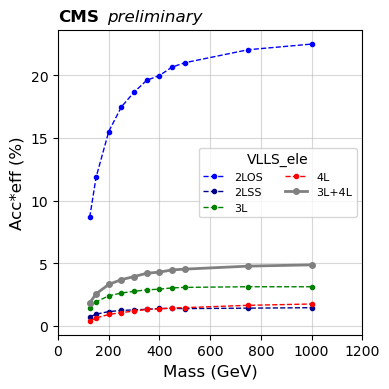

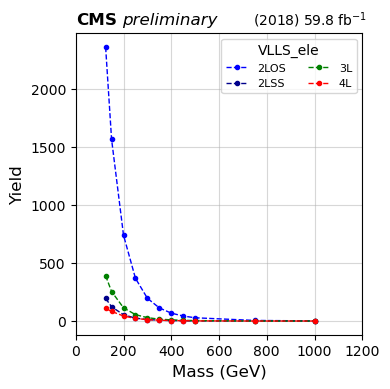

In [6]:
make_plot("VLLS_ele")

Yield (acceptance %) for VLLS_mu :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	594746	2813 (5.2%)	5105 (9.4%)	5986 (11.1%)	2217 (4.1%)	148 (0.3%)	229 (0.4%)	35 (0.1%)	
125	599690	1387 (5.1%)	3001 (11.0%)	6048 (22.2%)	3720 (13.7%)	224 (0.8%)	447 (1.6%)	173 (0.6%)	
150	598660	582 (4.4%)	1418 (10.7%)	3477 (26.3%)	2301 (17.4%)	118 (0.9%)	278 (2.1%)	125 (1.0%)	
200	599555	155 (3.3%)	456 (9.6%)	1470 (30.8%)	995 (20.9%)	48 (1.0%)	119 (2.5%)	57 (1.2%)	
250	496540	52 (2.5%)	174 (8.3%)	707 (33.5%)	479 (22.8%)	21 (1.0%)	58 (2.8%)	28 (1.4%)	
300	499438	20 (2.0%)	76 (7.3%)	372 (35.3%)	251 (23.8%)	11 (1.1%)	30 (2.9%)	15 (1.5%)	
400	198686	5 (1.5%)	20 (6.1%)	126 (36.9%)	86 (25.2%)	3 (1.0%)	10 (3.1%)	5 (1.7%)	
450	197673	2 (1.4%)	12 (5.9%)	79 (37.6%)	53 (25.4%)	2 (1.0%)	6 (3.1%)	3 (1.7%)	
500	199603	1 (1.2%)	7 (5.6%)	50 (37.7%)	34 (25.9%)	1 (1.0%)	4 (3.1%)	2 (1.8%)	
750	99672	0 (0.9%)	1 (6.0%)	8 (37.6%)	6 (27.0%)	0 (1.0%)	0 (3.2%)	0 (1.9%)	
1000	99496	0 (0.8%)	0 (6.9%)	1 (37.0%)	1 (27.5

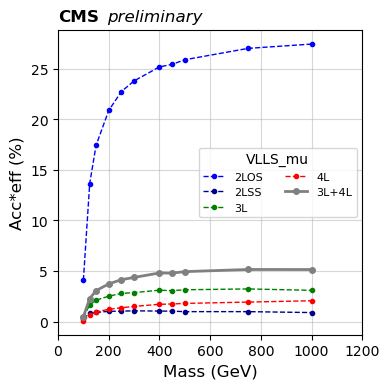

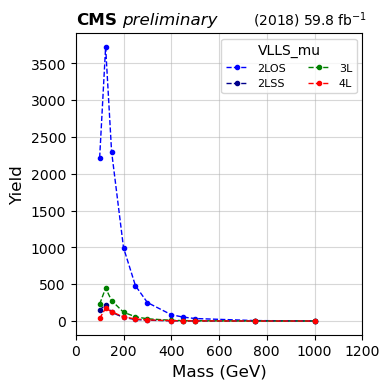

In [7]:
make_plot("VLLS_mu")

Yield (acceptance %) for VLLD_ele :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	110871	35200 (4.6%)	76028 (9.9%)	176155 (22.9%)	107011 (13.9%)	30393 (3.9%)	31602 (4.1%)	3959 (0.5%)	
200	73730	901 (1.5%)	3051 (5.0%)	16055 (26.3%)	24183 (39.6%)	2875 (4.7%)	6794 (11.1%)	1444 (2.4%)	
300	24753	79 (0.6%)	383 (2.9%)	3284 (24.5%)	6054 (45.2%)	613 (4.6%)	1762 (13.1%)	410 (3.1%)	
400	24491	14 (0.3%)	76 (1.8%)	1000 (23.3%)	2062 (48.0%)	199 (4.6%)	590 (13.7%)	142 (3.3%)	
600	24611	2 (0.4%)	12 (1.7%)	178 (23.7%)	355 (47.2%)	35 (4.7%)	106 (14.2%)	23 (3.1%)	
800	23680	0 (0.1%)	2 (1.1%)	37 (19.9%)	96 (50.5%)	9 (4.8%)	30 (15.9%)	6 (3.6%)	
1000	24286	0 (0.1%)	0 (1.1%)	11 (19.3%)	29 (51.5%)	2 (4.7%)	9 (15.6%)	2 (4.0%)	

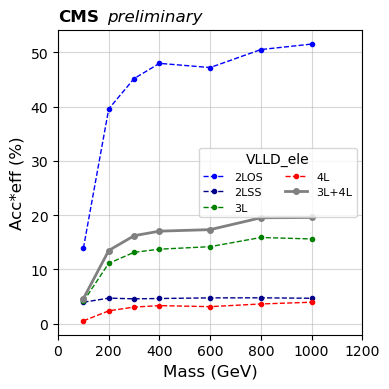

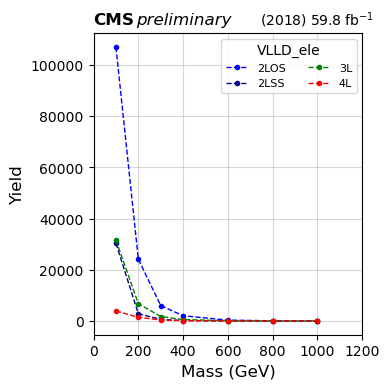

In [8]:
make_plot("VLLD_ele")

Yield (acceptance %) for VLLD_mu :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	111926	33334 (4.3%)	63619 (8.3%)	140238 (18.2%)	229059 (29.7%)	28001 (3.6%)	57495 (7.5%)	7480 (1.0%)	
200	73908	800 (1.3%)	2097 (3.4%)	7240 (11.8%)	35339 (57.8%)	1340 (2.2%)	8740 (14.3%)	1992 (3.3%)	
300	25022	64 (0.5%)	243 (1.8%)	1476 (11.0%)	8147 (60.8%)	258 (1.9%)	2165 (16.2%)	512 (3.8%)	
400	24299	9 (0.2%)	42 (1.0%)	402 (9.4%)	2699 (62.8%)	73 (1.7%)	738 (17.2%)	174 (4.0%)	
600	24890	0 (0.1%)	5 (0.7%)	60 (8.0%)	482 (64.1%)	11 (1.5%)	137 (18.2%)	31 (4.2%)	
800	24763	0 (0.1%)	1 (0.6%)	14 (7.4%)	122 (64.5%)	2 (1.5%)	34 (18.2%)	9 (4.7%)	

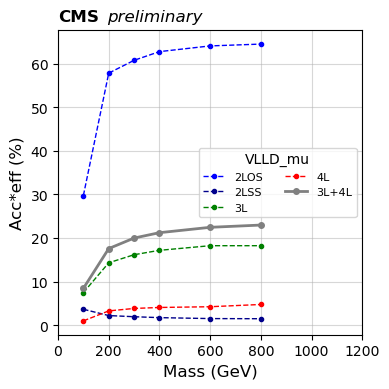

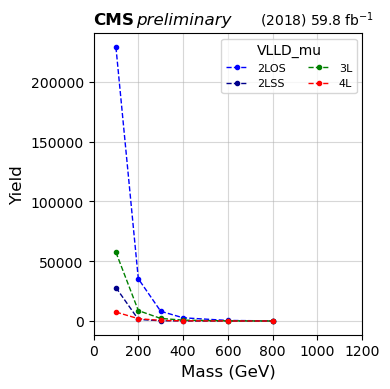

In [9]:
make_plot("VLLD_mu")

In [ ]:
make_plot("VLLS_tau")